# Introduction

탐색적 자료 분석을 통해 몇몇 관측값에서 '이상한 값'을 보이는 것을 확인 할 수 있었다.

이번 커널에서는 '이상한 값'을 탐지하여 예측 모델의 성능을 상승시키는 것을 목적으로 한다. 사용 알고리즘은 다음과 같다.

- Isolation Forest

# Import Module

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [99]:
train = pd.read_csv('../dataset/train.csv', index_col = 0)
test = pd.read_csv('../dataset/test.csv', index_col = 0)
sample_submission = pd.read_csv('../dataset/sample_submission.csv', index_col = 0)

In [100]:
X_train = train.drop(columns = 'type')
y_train = train['type']

num_X_train = X_train.drop(columns = 'fiberID')
num_X_test = test.drop(columns = 'fiberID')

model = IsolationForest(random_state = 42, contamination = 0.03)
model.fit(num_X_train)

outlier_pred = model.predict(num_X_train)

In [101]:
train['if_outlier'] = outlier_pred

train['if_outlier'].value_counts()

 1    189991
-1     10000
Name: if_outlier, dtype: int64

In [102]:
train_no_outlier = train.loc[train['if_outlier'] == 1]
train_no_outlier.drop(columns = ['if_outlier'], inplace = True)

In [103]:
train_no_outlier['type'].nunique()

19

In [104]:
train_no_outlier.loc[train_no_outlier['type'] == 'SKY']

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,...,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,
173609,SKY,497,23.141471,22.510971,21.720823,21.323619,21.647005,23.134519,23.307475,21.916679,...,22.280071,25.152498,21.892286,21.541997,21.695445,23.582121,22.300735,21.596937,21.393984,21.752769


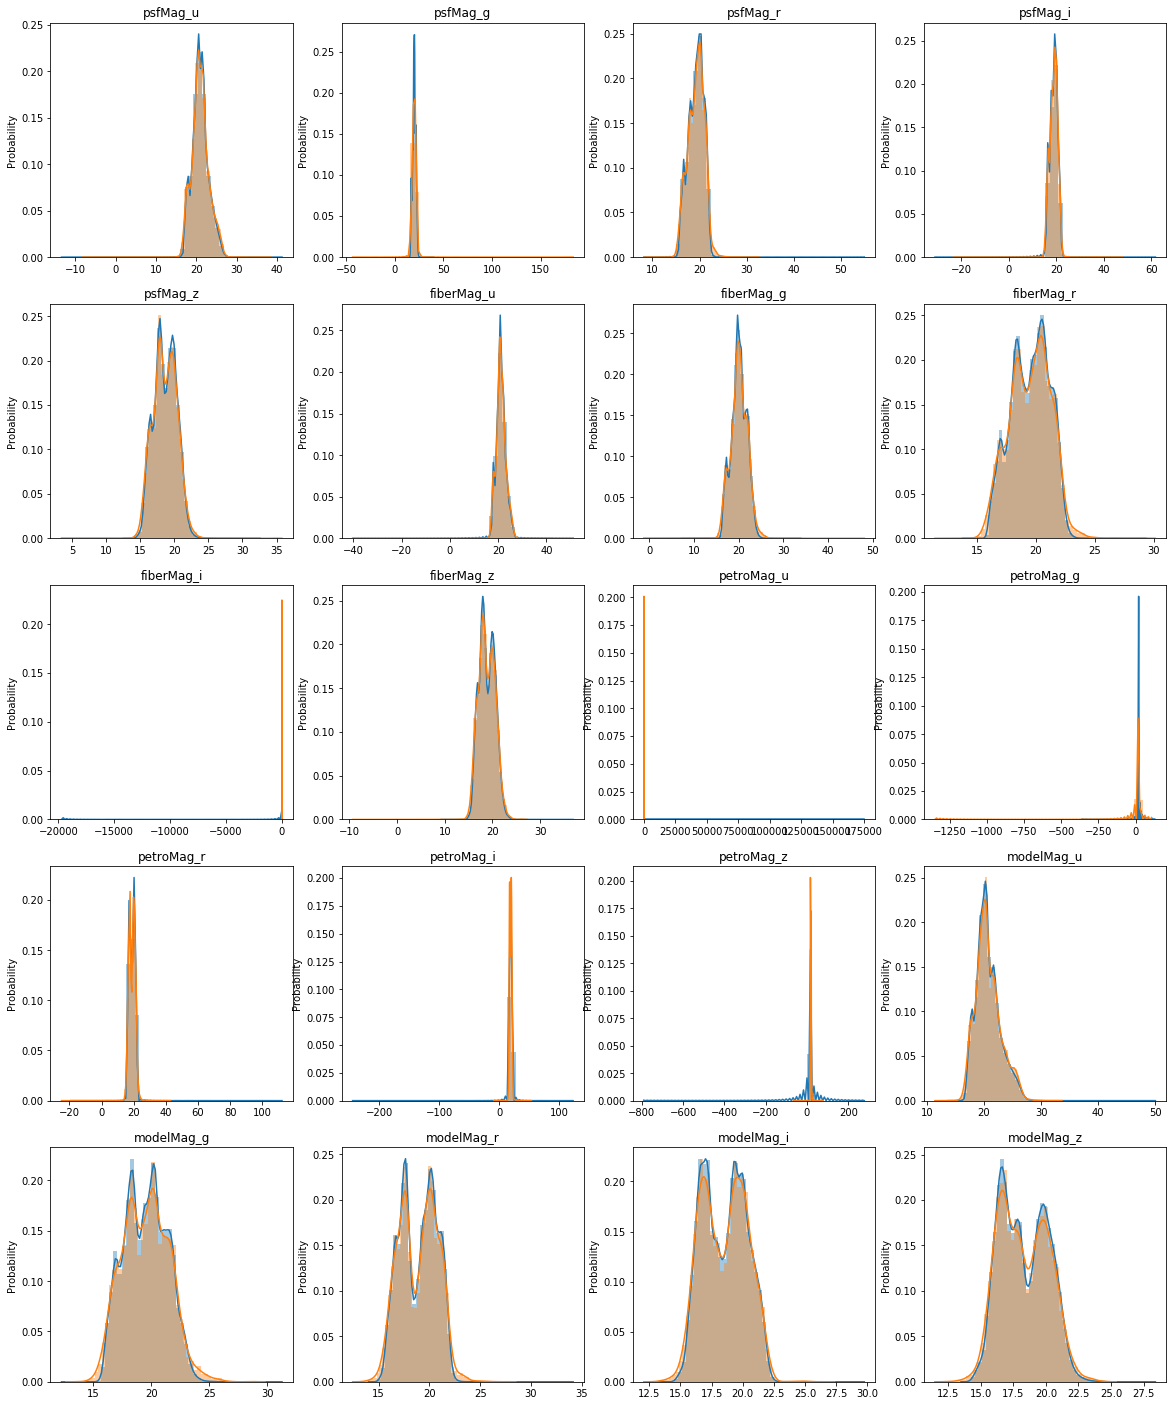

In [98]:
f = plt.figure(figsize = (20,25))

for i, col in enumerate(train_no_outlier.drop(columns = ['type', 'fiberID']).columns):
    f.add_subplot(5, 4, i+1)
    
    sns.distplot(train_no_outlier[col])
    sns.distplot(test[col])
    
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Probability')

Isolation Forest를 이용하여 훈련 데이터에서 Outlier를 제외한결과, 테스트 데이터의 분포와 비슷해졌다는 것을 알 수 있다. 

In [79]:
fiberID_mean = train_no_outlier.groupby('fiberID').mean()
#fiberID_mean.reset_index(inplace = True)

fiberID_median = train_no_outlier.groupby('fiberID').median()
#fiberID_median.reset_index(inplace = True)

fiberID_std = train_no_outlier.groupby('fiberID').std()
#fiberID_std.reset_index(inplace = True)

In [80]:
def VisFeature(data, method = 'hist', sep = False, scale = None):
    
    
    if method == 'hist':
        #data = data.drop(columns = 'fiberID_group')

        f = plt.figure(figsize = (30,30))
        
        for i, col in enumerate(data.columns):
            f.add_subplot(6,4,i+1)
            sns.distplot(data[col])
            plt.title(col, fontsize = 14)
            plt.xlabel(' ')
            plt.ylabel('Density', fontsize = 12)
    
    if method == 'line':
        if sep == False:
            
            #data = data.drop(columns = 'fiberID_group')
        
            f = plt.figure(figsize = (30, 30))
        
            for i, col in enumerate(data.columns):
                f.add_subplot(6, 4, i+1)
                plt.plot(data[col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)
                
        elif sep == True:
            
            #data = data.drop(columns = 'fiberID_group')

            f = plt.figure(figsize = (30,30))
            
            for i, col in enumerate(data):
                f.add_subplot(6, 4, i+1)
                plt.plot(data.iloc[:640][col])
                plt.plot(data.iloc[640:][col])
                plt.title(col, fontsize = 14)
                plt.xlabel('fiberID Index', fontsize = 12)
                plt.ylabel('Value', fontsize = 12)

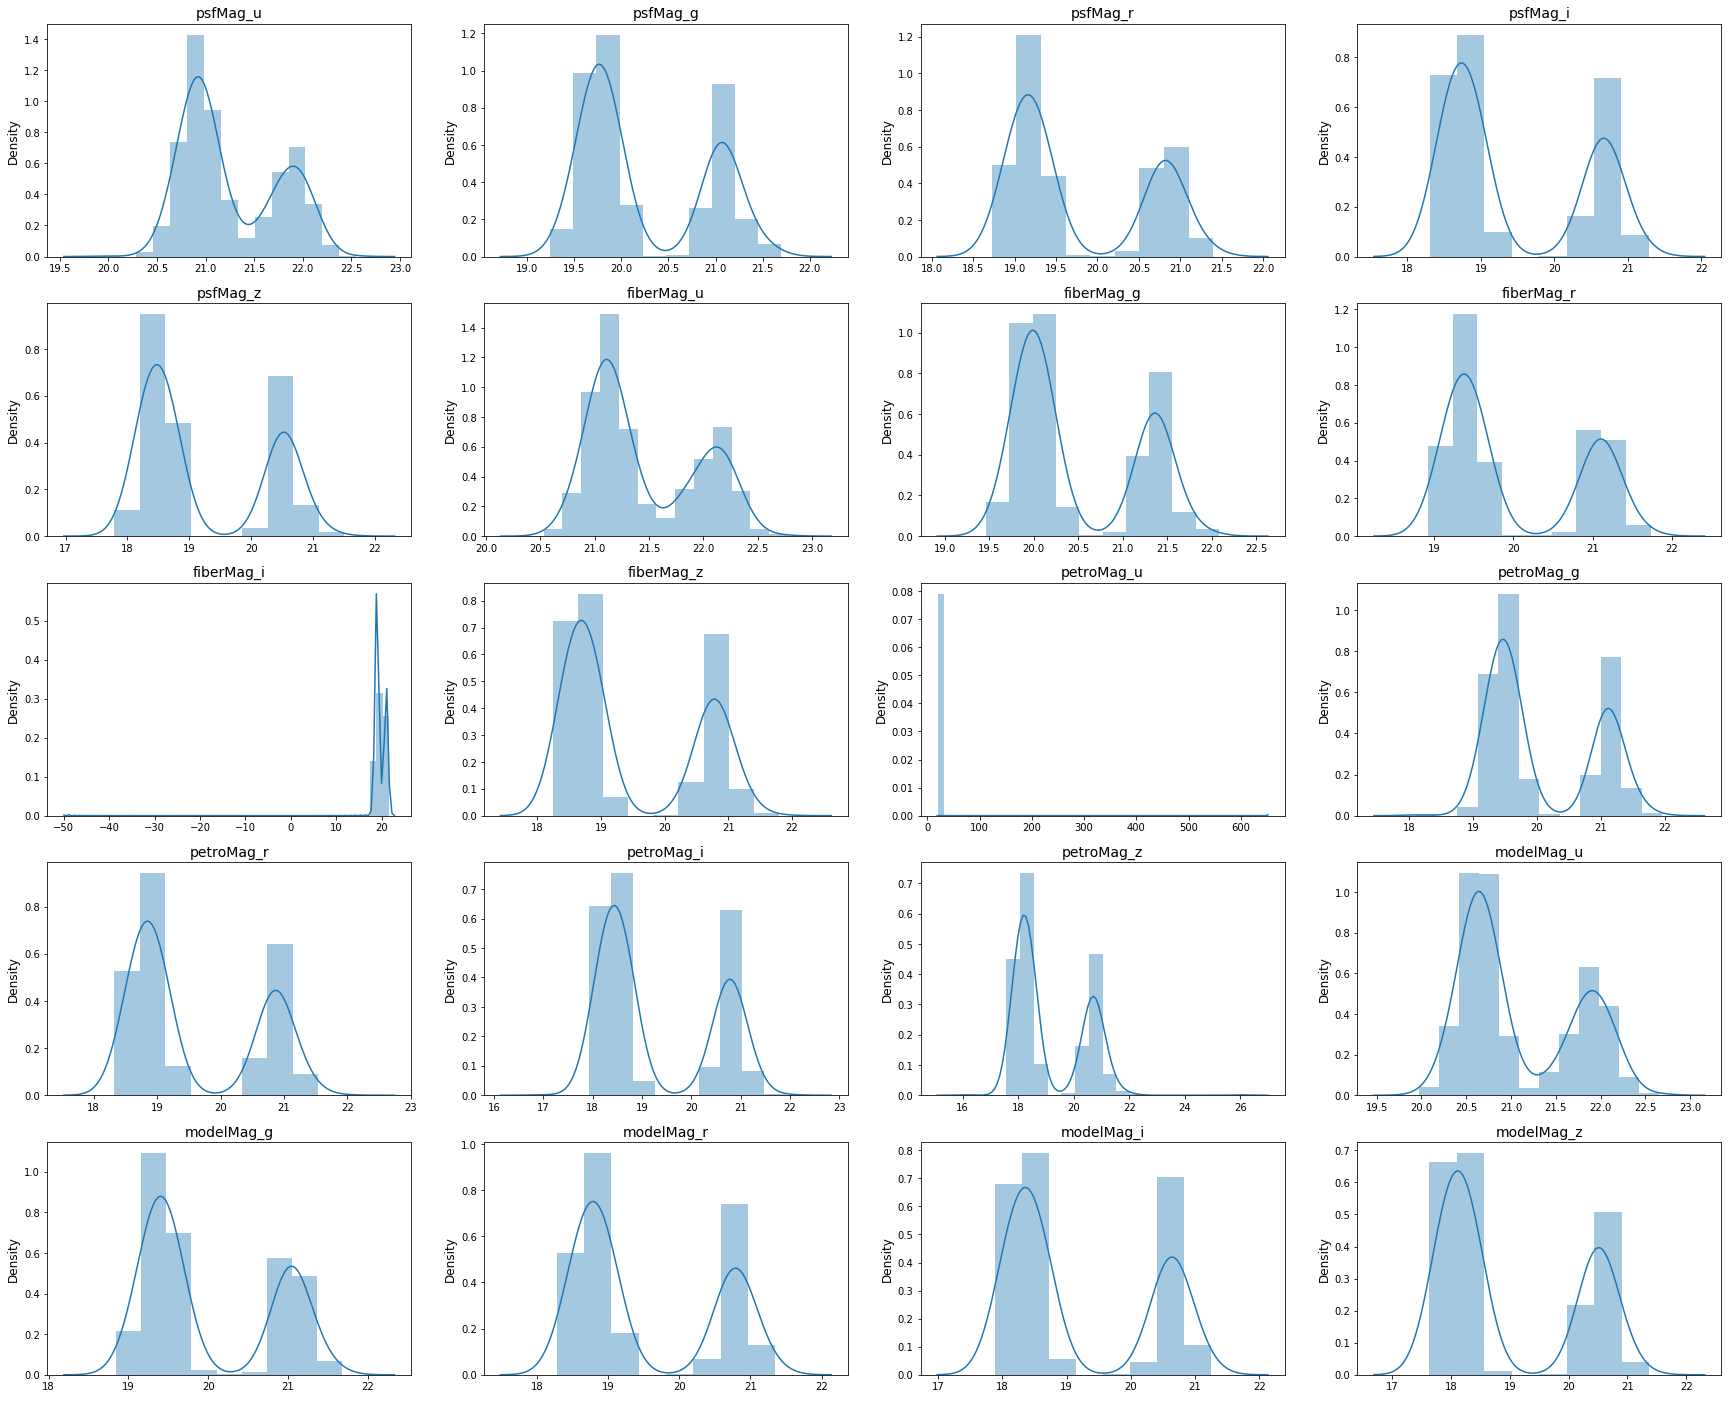

In [81]:
VisFeature(fiberID_mean)

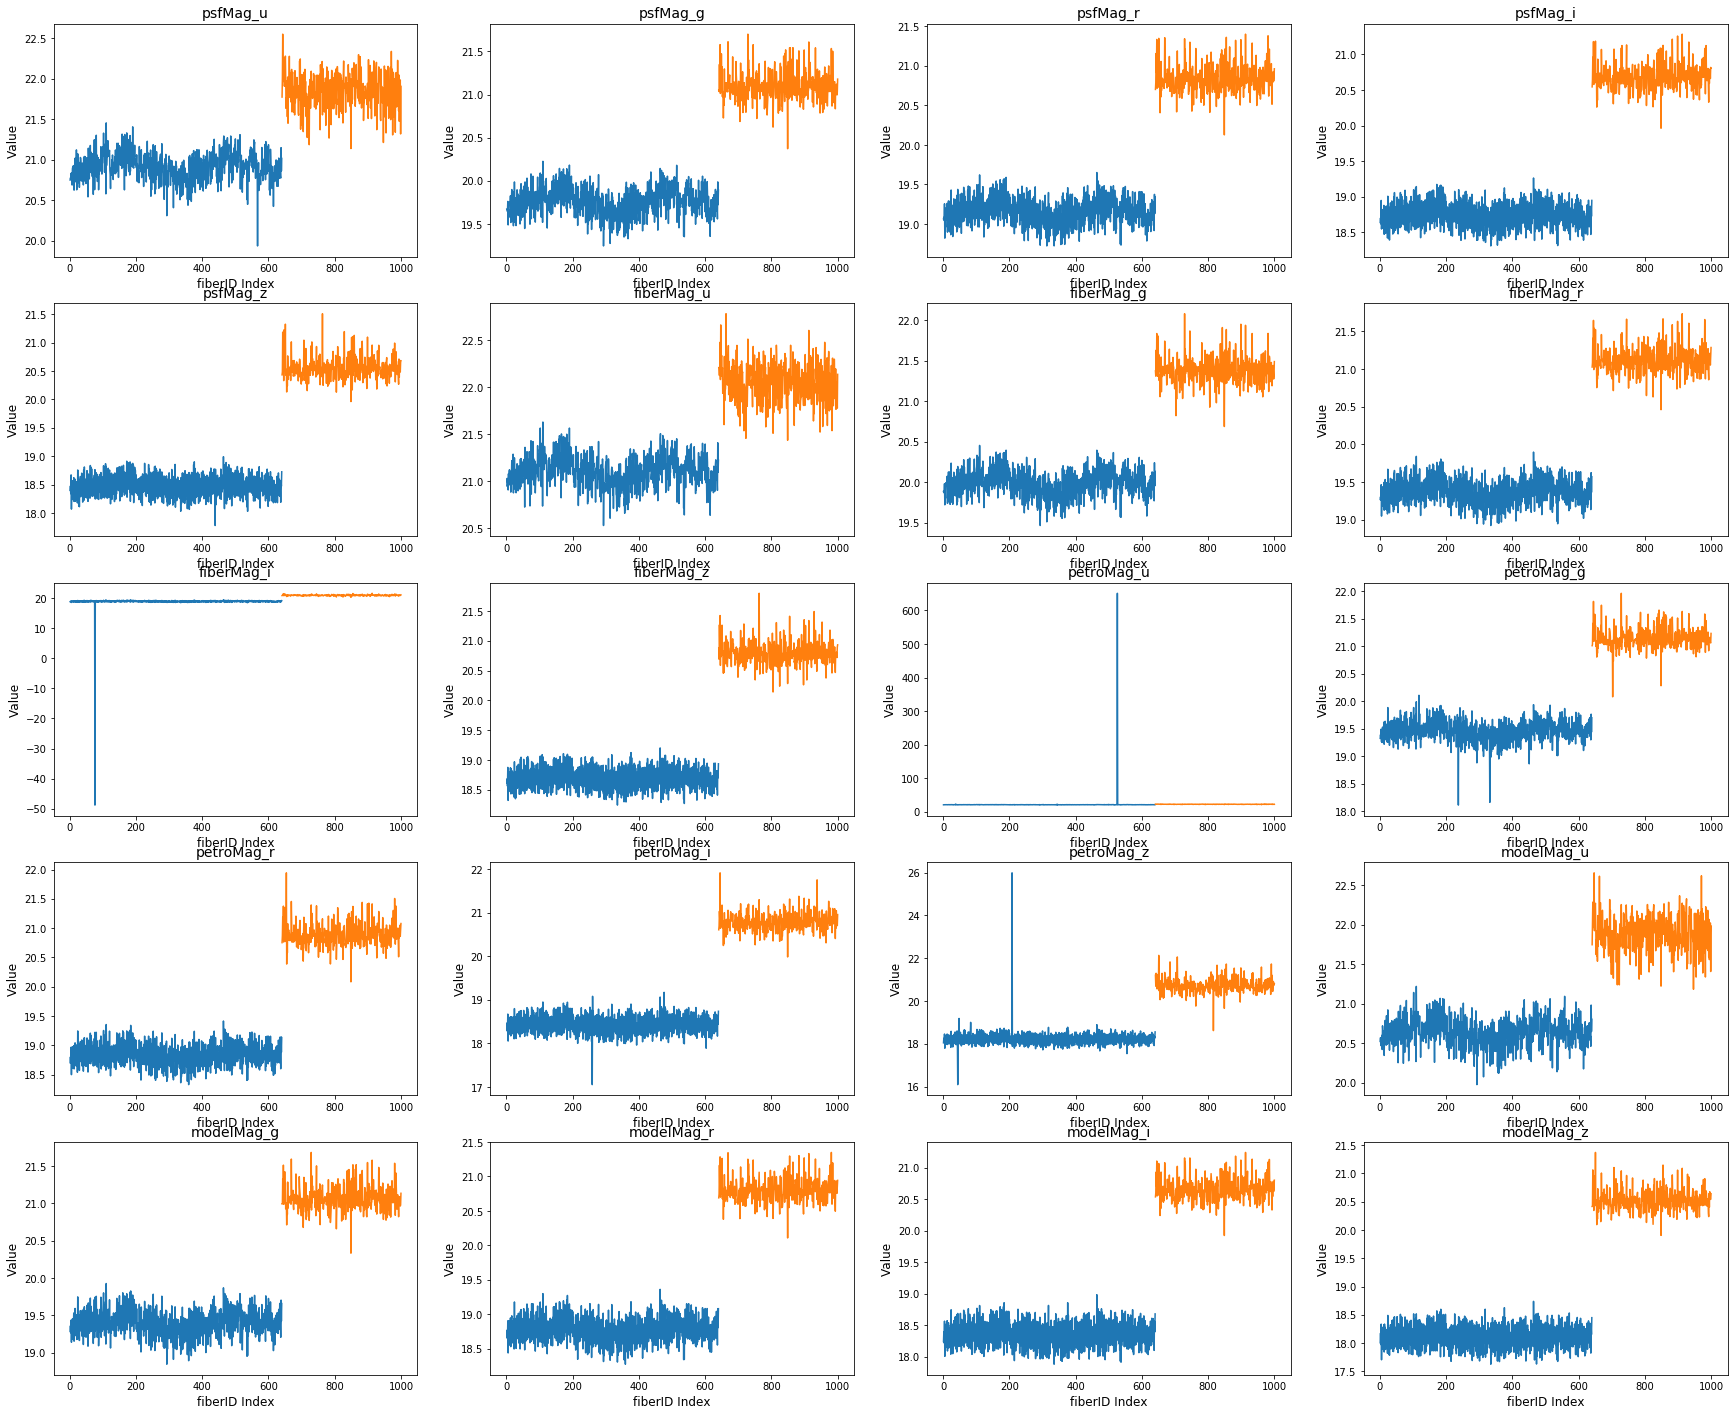

In [82]:
VisFeature(fiberID_mean, method = 'line', sep = True)

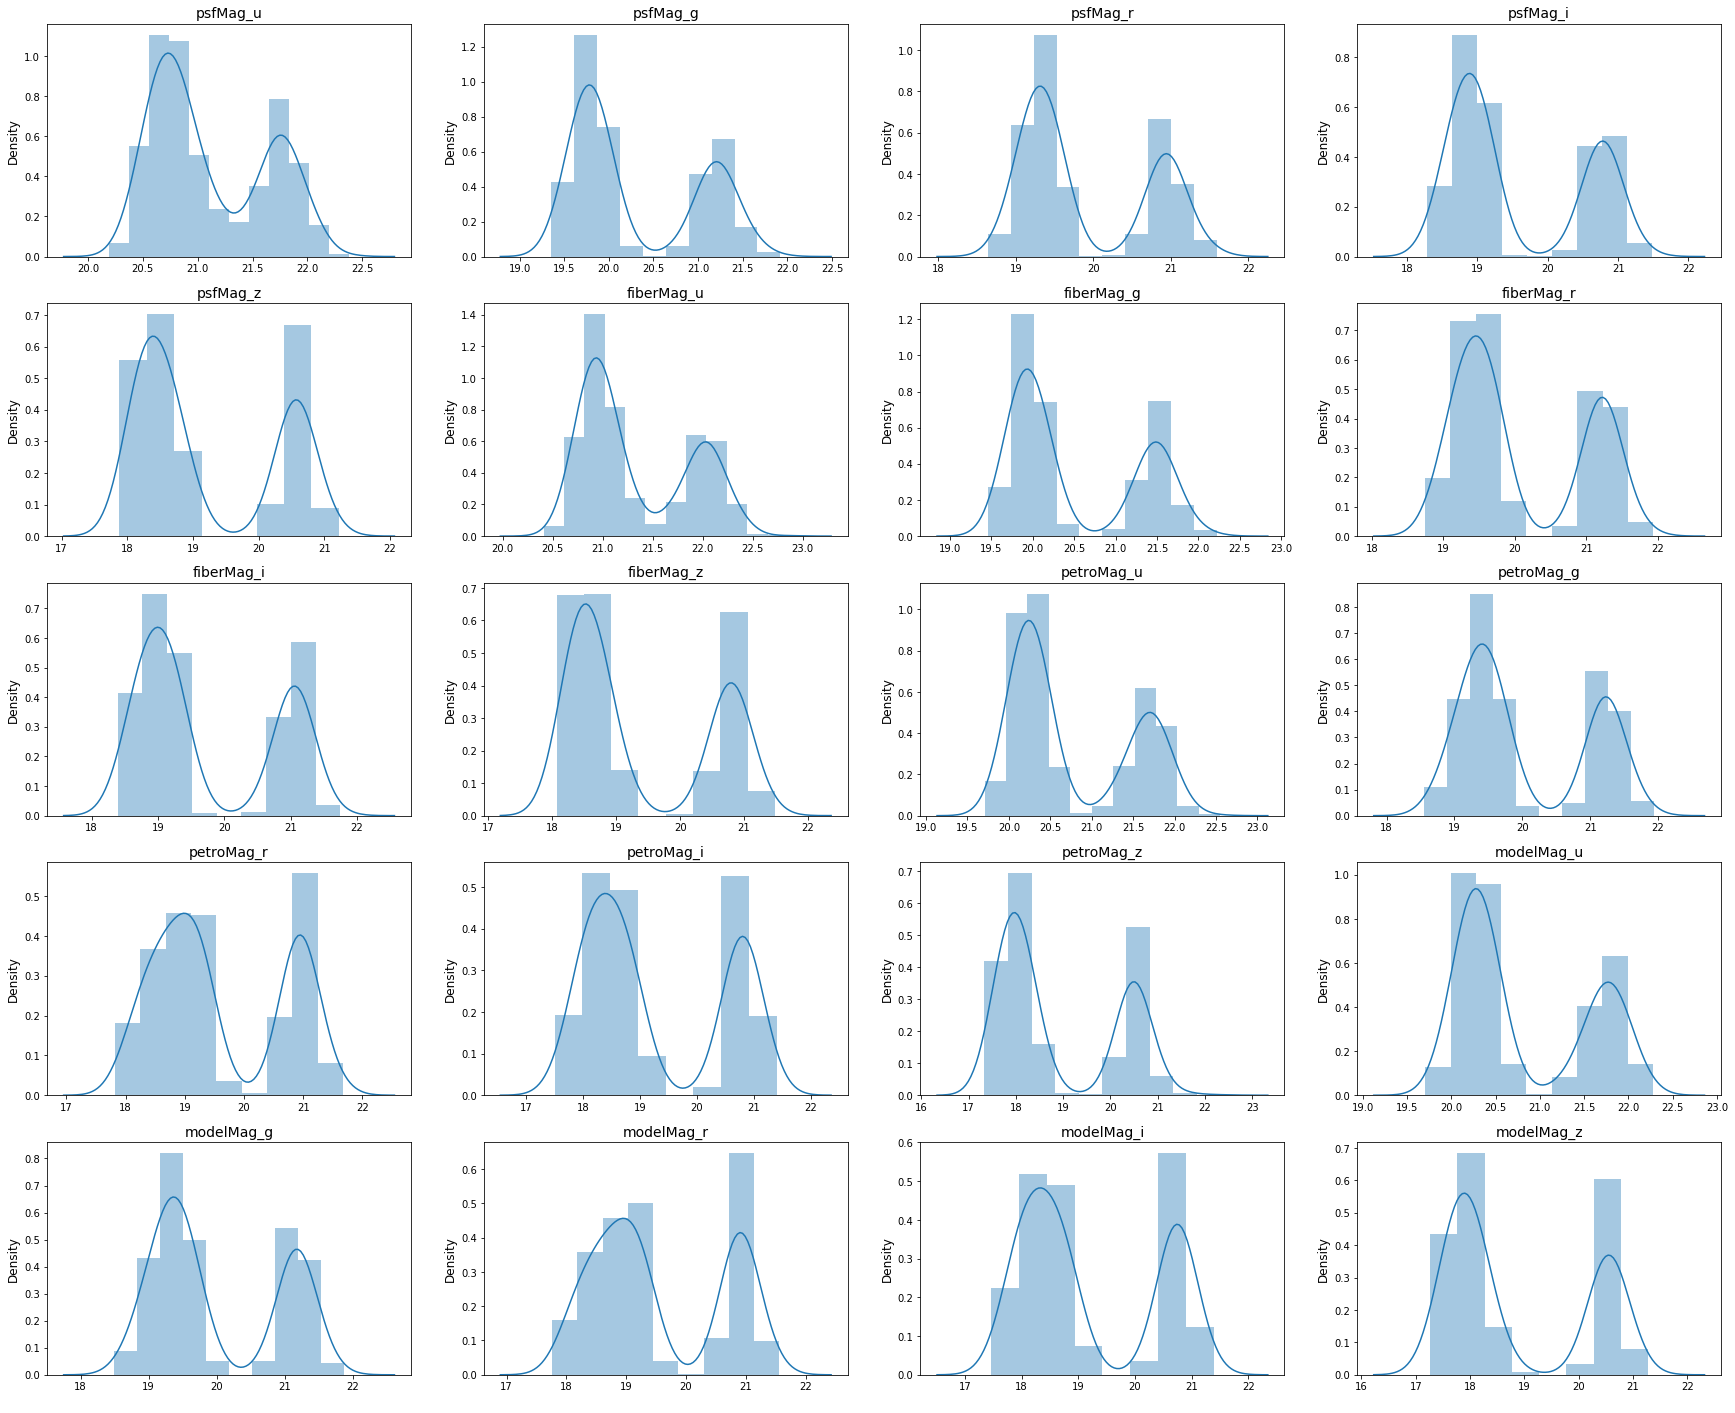

In [83]:
VisFeature(fiberID_median)

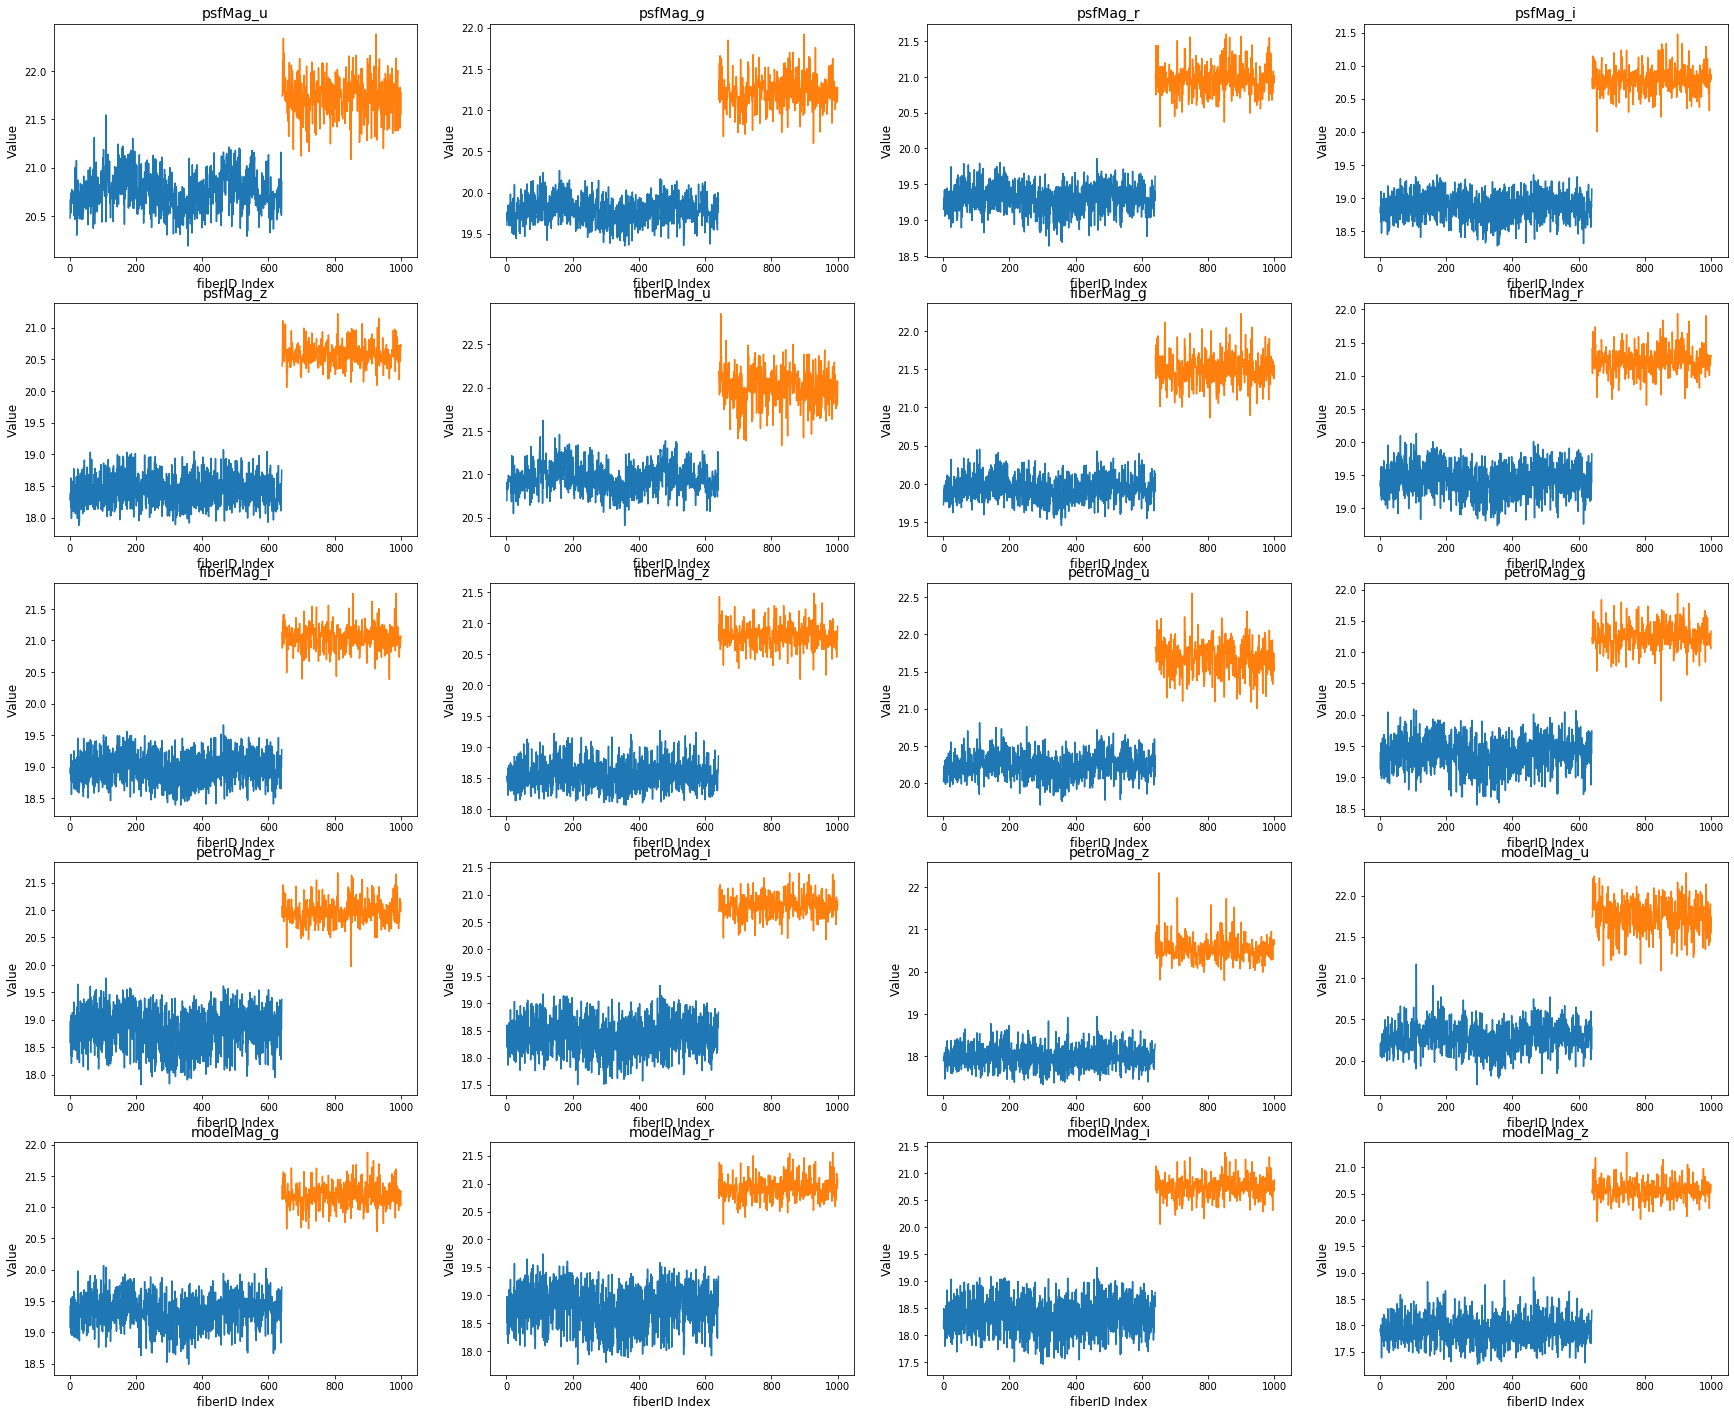

In [84]:
VisFeature(fiberID_median, method = 'line', sep = True)

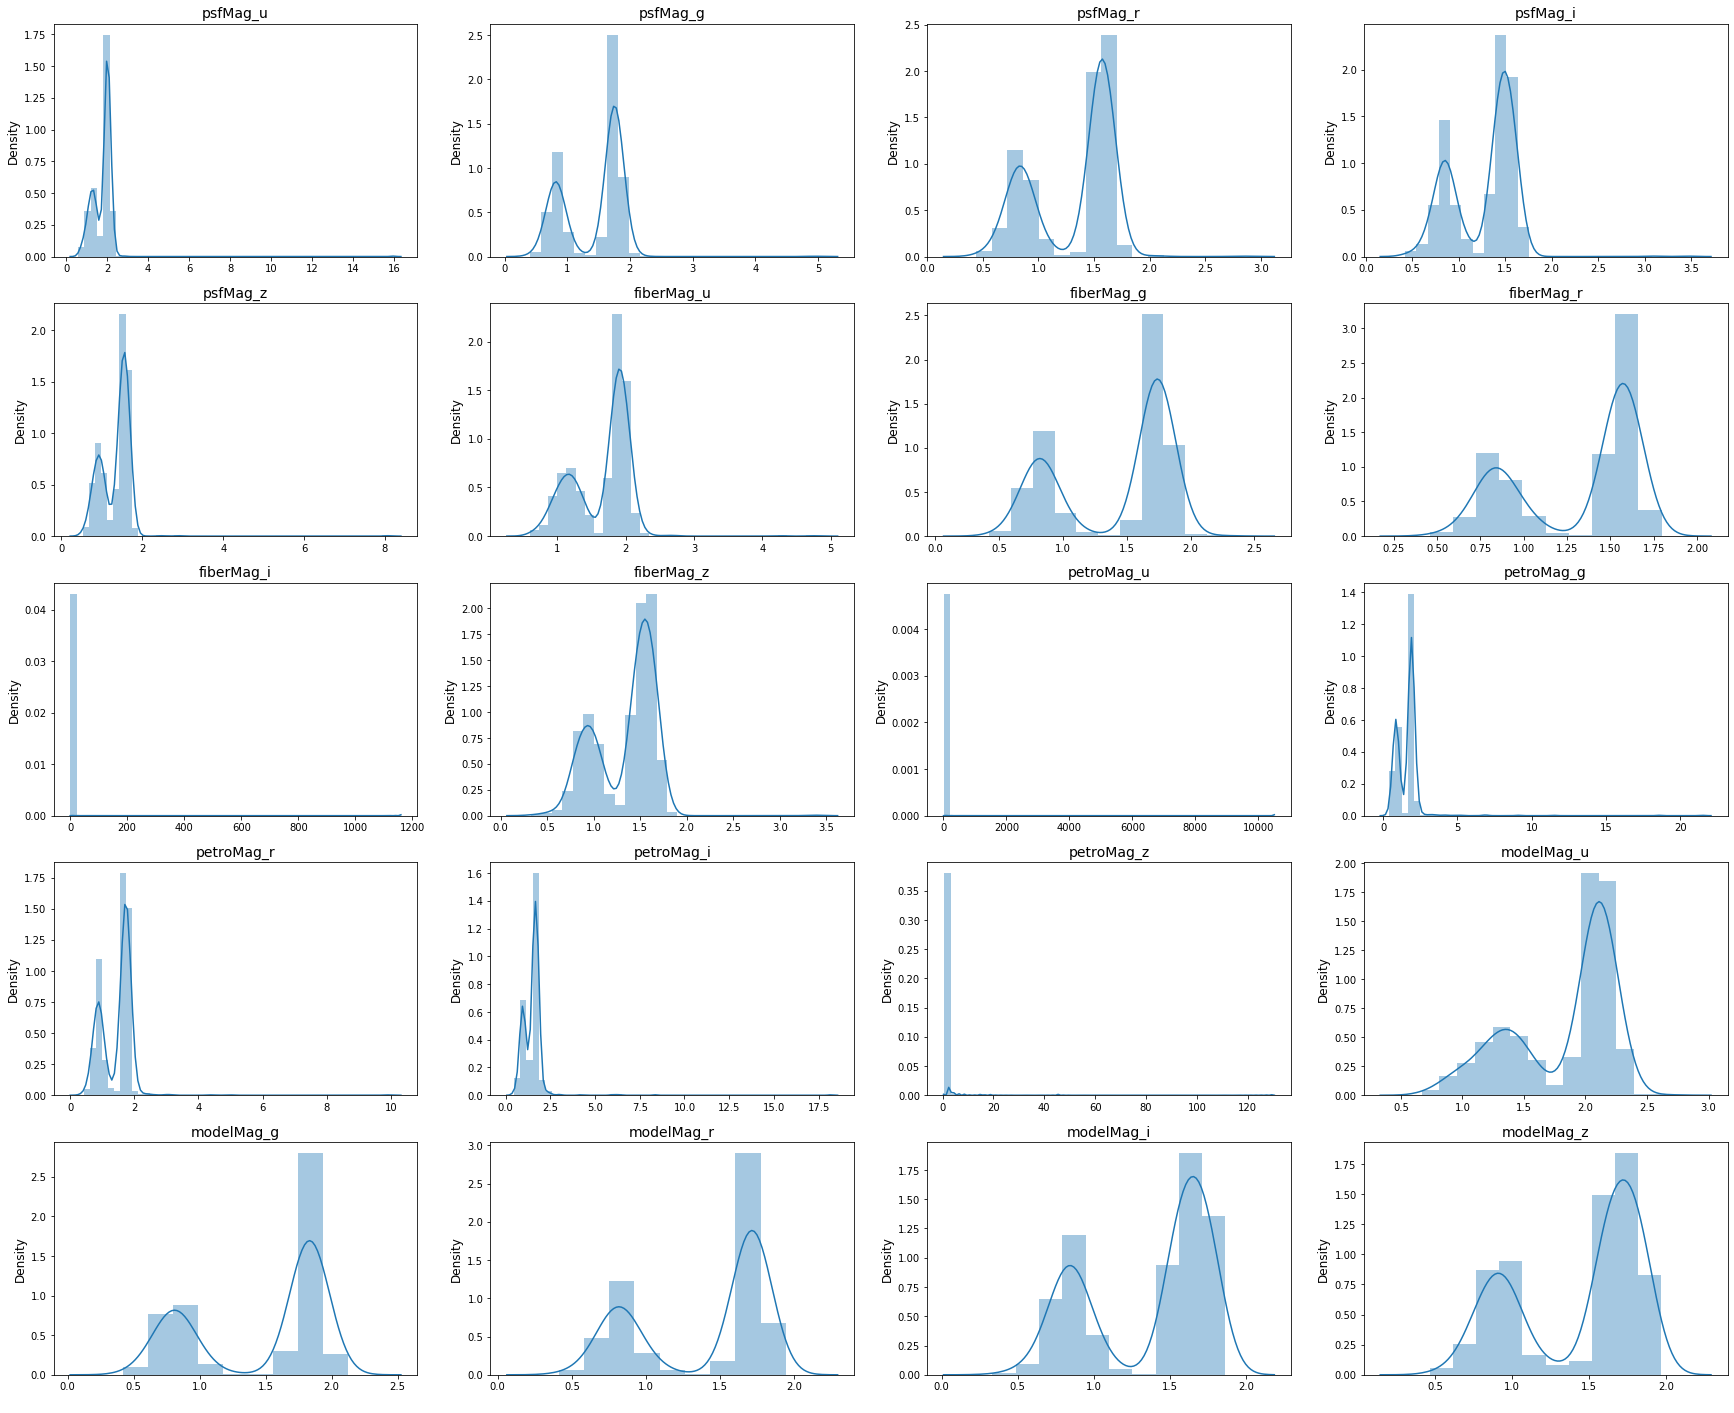

In [85]:
VisFeature(fiberID_std)

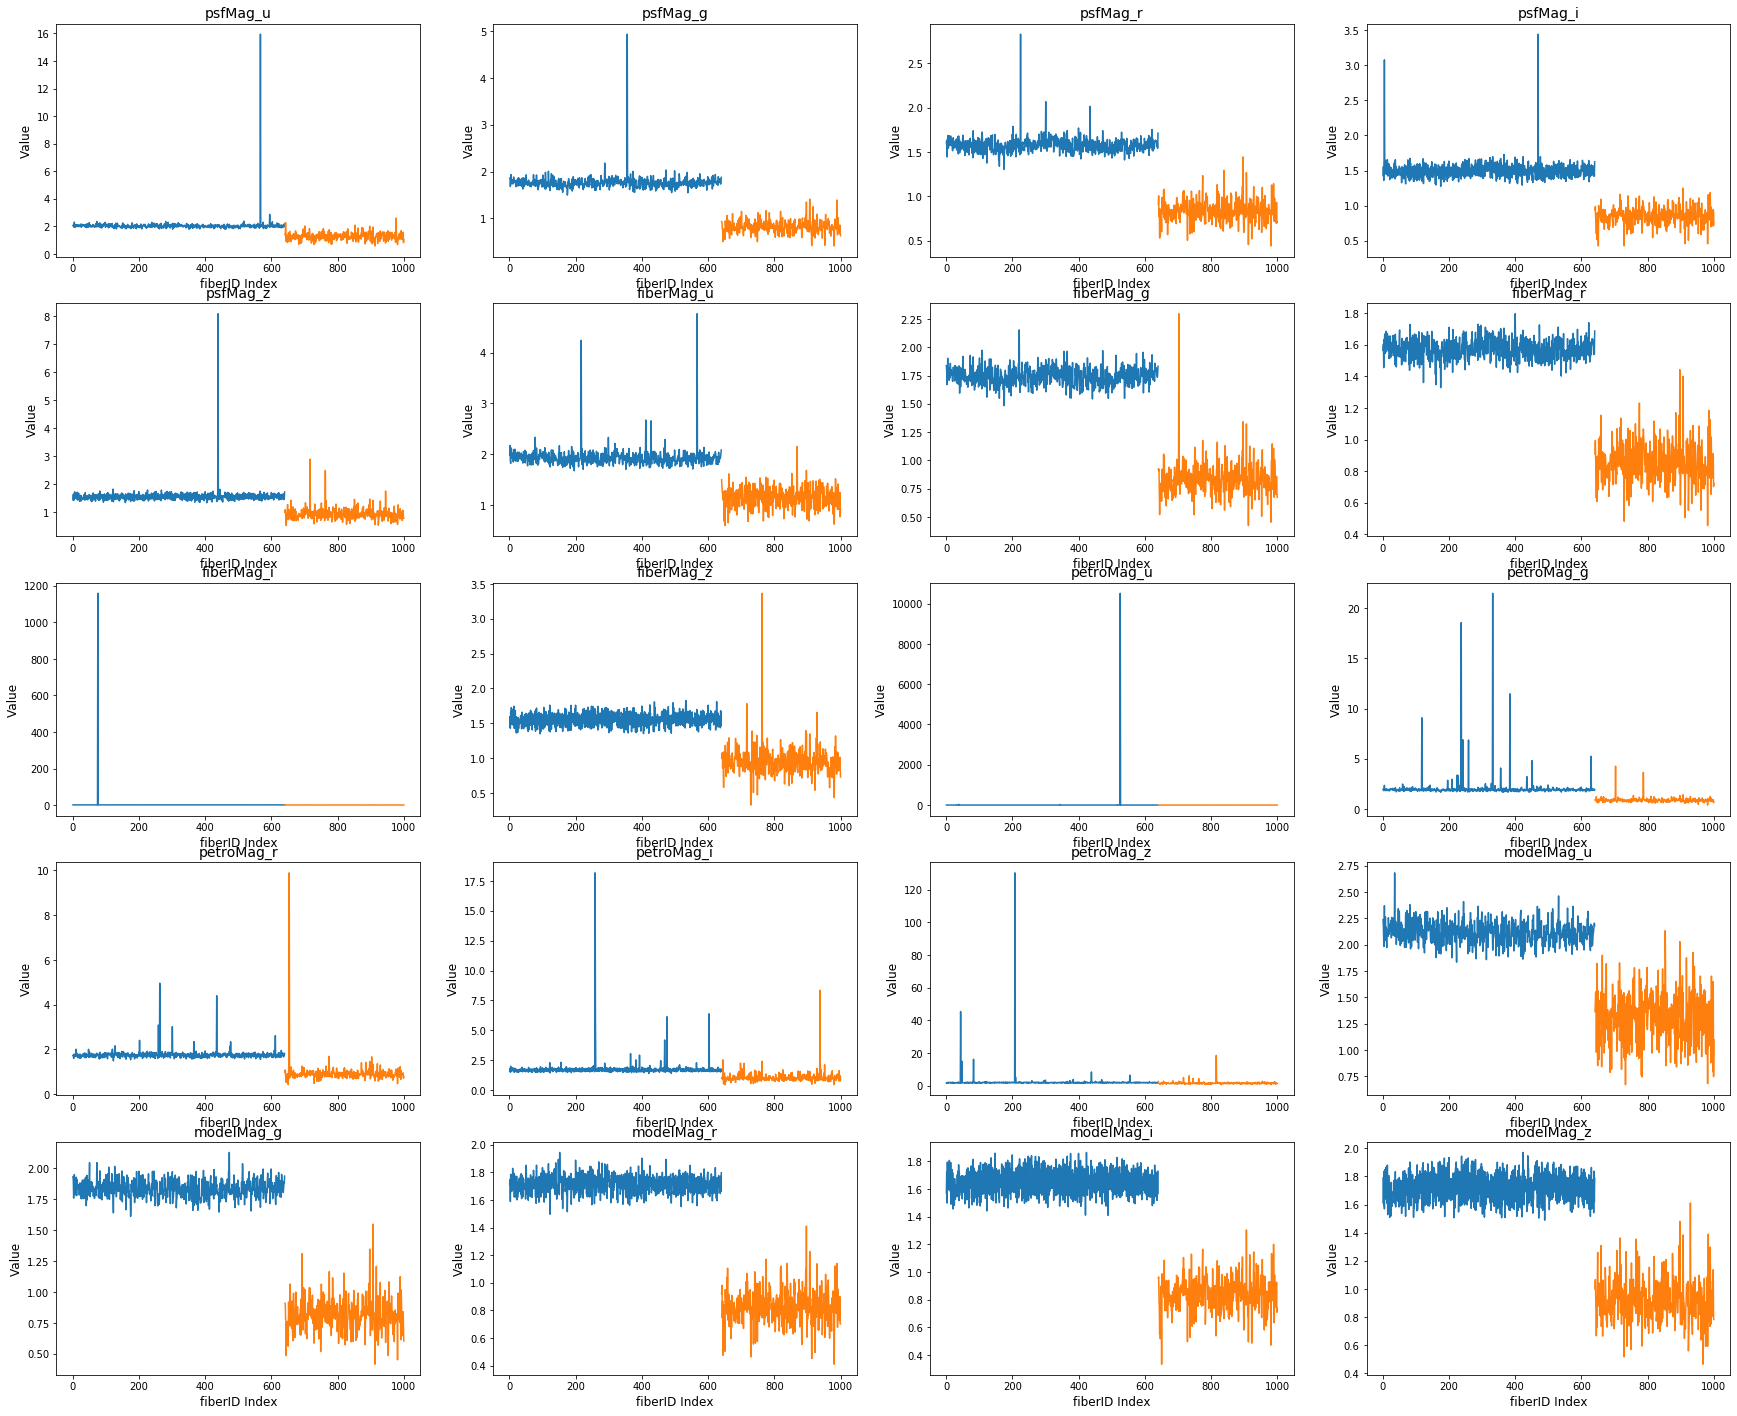

In [86]:
VisFeature(fiberID_std, method = 'line', sep = True)

# k-Means Clustering

In [87]:
X_train = train_no_outlier.drop(columns = 'type')
y_train = train_no_outlier['type']

psfMag_train = X_train[['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']]
scaler = StandardScaler()
psfMag_train_scaler = scaler.fit_transform(psfMag_train)

pca = PCA(n_components = 2)
psf_pca = pca.fit_transform(psfMag_train_scaler)
print(pca.explained_variance_ratio_)
psf_pca_scaler_df = pd.DataFrame(psf_pca)

[0.79239409 0.17012578]


## psfMag

In [88]:
x = psf_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

KeyboardInterrupt: 

In [ ]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

In [ ]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1])

plt.show()

In [ ]:
train_no_outlier['psf_cluster'] = y_means

In [ ]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 0]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 1]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 2]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 3]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['psf_cluster'] == 4]['type'].value_counts()

## fiberMag

In [ ]:
fiberMag_train = X_train[['fiberMag_u', 'fiberMag_g', 'fiberMag_r', 'fiberMag_i', 'fiberMag_z']]

scaler = StandardScaler()
fiberMag_train_scaler = scaler.fit_transform(fiberMag_train)

pca = PCA(n_components = 2)
fiber_pca = pca.fit_transform(fiberMag_train_scaler)
print(pca.explained_variance_ratio_)
fiber_pca_scaler_df = pd.DataFrame(fiber_pca)

In [ ]:
x = fiber_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [ ]:
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

In [ ]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])
plt.scatter(x[y_means == 4, 0], x[y_means == 4, 1])

plt.show()

In [ ]:
train_no_outlier['fiber_cluster'] = y_means

In [ ]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 0]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 1]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 2]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 3]['type'].value_counts()

In [ ]:
train_no_outlier.loc[train_no_outlier['fiber_cluster'] == 4]['type'].value_counts()

## petroMag

In [ ]:
petroMag_train = X_train[['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z']]

scaler = StandardScaler()
petroMag_train_scaler = scaler.fit_transform(petroMag_train)

pca = PCA(n_components = 2)
petro_pca = pca.fit_transform(petroMag_train_scaler)
print(pca.explained_variance_ratio_)
petro_pca_scaler_df = pd.DataFrame(petro_pca)

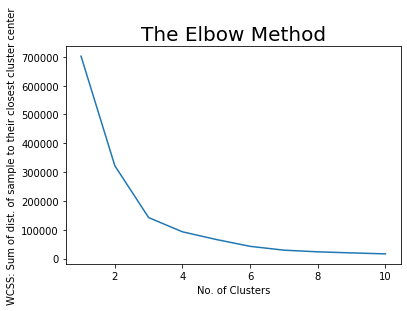

In [88]:
x = petro_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [89]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

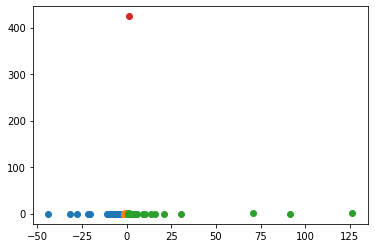

In [90]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])

plt.show()

## modelMag

In [91]:
modelMag_train = X_train[['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z']]

scaler = StandardScaler()
modelMag_train_scaler = scaler.fit_transform(modelMag_train)

pca = PCA(n_components = 2)
model_pca = pca.fit_transform(modelMag_train_scaler)
print(pca.explained_variance_ratio_)
model_pca_scaler_df = pd.DataFrame(model_pca)

[0.82318863 0.1585945 ]


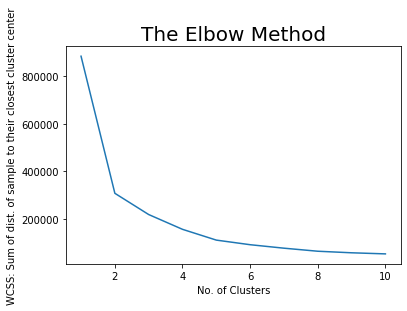

In [92]:
x = model_pca_scaler_df.values

wcss = []

for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    km.fit(x)
    
    wcss.append(km.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS: Sum of dist. of sample to their closest cluster center')
plt.show()

In [94]:
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_means = km.fit_predict(x)

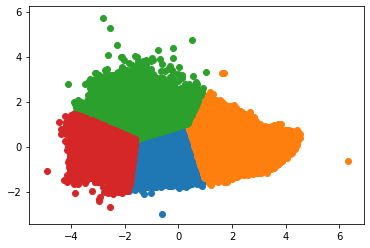

In [96]:
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1])
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1])
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1])
plt.scatter(x[y_means == 3, 0], x[y_means == 3, 1])

plt.show()

In [98]:
train_no_outlier['model_cluster'] = y_means

In [99]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 0]['type'].value_counts()

SERENDIPITY_BLUE       19371
QSO                    12850
STAR_BHB                5935
SERENDIPITY_DISTANT     3401
SERENDIPITY_FIRST       2382
ROSAT_D                 2317
STAR_WHITE_DWARF        1614
STAR_CARBON              427
GALAXY                   397
STAR_CATY_VAR            262
REDDEN_STD                65
SERENDIPITY_MANUAL        18
STAR_PN                    9
SERENDIPITY_RED            2
STAR_SUB_DWARF             2
Name: type, dtype: int64

In [100]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 1]['type'].value_counts()

GALAXY                 31119
REDDEN_STD             14548
SPECTROPHOTO_STD       11316
STAR_BHB                6172
STAR_CATY_VAR           5277
QSO                     2613
ROSAT_D                 1299
STAR_CARBON             1143
SERENDIPITY_DISTANT      489
SERENDIPITY_FIRST        404
STAR_WHITE_DWARF         394
SERENDIPITY_BLUE         266
STAR_SUB_DWARF           107
STAR_RED_DWARF            44
SERENDIPITY_MANUAL         8
STAR_PN                    1
Name: type, dtype: int64

In [101]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 2]['type'].value_counts()

STAR_RED_DWARF         10413
SERENDIPITY_FIRST       3520
GALAXY                  3489
QSO                     2322
ROSAT_D                 1849
STAR_CARBON             1461
STAR_SUB_DWARF           993
SERENDIPITY_RED           61
STAR_WHITE_DWARF          20
SERENDIPITY_MANUAL        16
SERENDIPITY_DISTANT       15
STAR_CATY_VAR              5
STAR_BROWN_DWARF           3
SERENDIPITY_BLUE           3
Name: type, dtype: int64

In [102]:
train_no_outlier.loc[train_no_outlier['model_cluster'] == 3]['type'].value_counts()

QSO                    27776
SERENDIPITY_BLUE        2042
SERENDIPITY_FIRST        654
SERENDIPITY_DISTANT      534
ROSAT_D                  505
GALAXY                    35
STAR_BHB                  10
STAR_RED_DWARF             5
STAR_WHITE_DWARF           3
SERENDIPITY_MANUAL         3
SERENDIPITY_RED            2
STAR_PN                    1
Name: type, dtype: int64

In [104]:
train_no_outlier.to_csv('../dataset/del_outlier_clustering_train.csv')